In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.8 MB/s eta 0:00:00


In [ ]:
# ==============================================================================
# PROJETO: Alocação de Recursos de Workflow com GNNs e PyTorch
#
# Abordagem: Modelo 2 (Não-Supervisionado com GNN Alocadora e GNN Avaliadora)
# Baseado em: "Unsupervised Resource Allocation with GNNs" (Cranmer et al., 2021)
#
# Este arquivo é um notebook Jupyter em formato .py.
# Você pode executá-lo célula por célula em um ambiente Jupyter (VS Code, Lab).
# ==============================================================================

# %%
# ==============================================================================
# CÉLULA 1: Instalação e Configuração de Imports
# ==============================================================================
#
# !pip install torch torch-geometric networkx matplotlib numpy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Imports do PyTorch Geometric (PyG)
import torch_geometric
from torch_geometric.data import HeteroData
from torch_geometric.nn import GATConv, HeteroConv, global_mean_pool

# Outras bibliotecas
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
import math

print(f"PyTorch Version: {torch.__version__}")
print(f"PyG Version: {torch_geometric.__version__}")

# Configurações
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

PyTorch Version: 2.9.0+cu126
PyG Version: 2.7.0


Número total de nós no DAG (incluindo source/sink): 12
Shape da Matriz de Tempos: (12, 3)
Shape da Matriz de Custos: (12, 3)


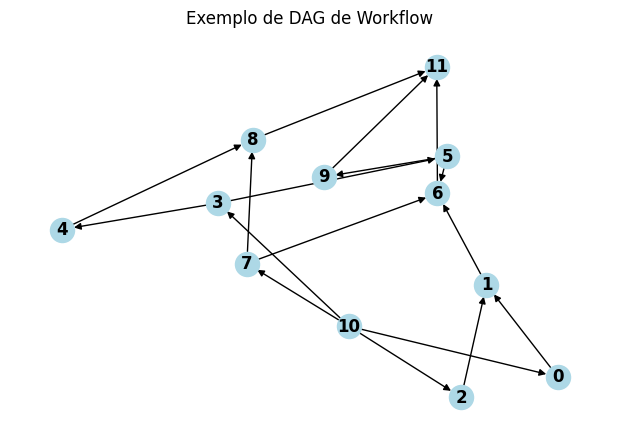

In [ ]:
# %%
# ==============================================================================
# CÉLULA 2: Geração de Dados Sintéticos (Problema)
# ==============================================================================
#
# Precisamos de duas coisas para um "problema":
# 1. Um workflow (DAG) de tarefas.
# 2. Uma matriz de custo/tempo (Tarefas x VMs).
#

def generate_workflow_dag(num_tasks: int, max_deps: int = 3, density: float = 0.2):
    """
    Gera um DAG de workflow aleatório usando NetworkX.
    Garante que é um DAG ao adicionar arestas apenas "para frente".
    """
    G = nx.DiGraph()
    nodes = list(range(num_tasks))
    random.shuffle(nodes) # Garante uma ordem topológica aleatória

    for i in range(1, num_tasks):
        node_i = nodes[i]
        possible_predecessors = nodes[:i]

        # Garante que cada tarefa (exceto a primeira) tenha pelo menos um predecessor
        # para criar um grafo mais conectado, mas isso é opcional.
        # Aqui, vamos focar na densidade.

        num_deps = 0
        for j in range(len(possible_predecessors)):
            if num_deps >= max_deps:
                break
            if random.random() < density:
                node_j = possible_predecessors[j]
                G.add_edge(node_j, node_i) # Aresta vai do predecessor para o sucessor
                num_deps += 1

    # Garante que o grafo é conectado (opcional, mas bom)
    # Vamos simplificar e assumir que a densidade cuida disso por enquanto.

    # Adiciona um nó "source" e "sink" para garantir início e fim únicos
    source = "source"
    sink = "sink"
    G.add_node(source)
    G.add_node(sink)

    roots = [node for node, in_degree in G.in_degree() if in_degree == 0 and node not in [source, sink]]
    leaves = [node for node, out_degree in G.out_degree() if out_degree == 0 and node not in [source, sink]]

    for root in roots:
        G.add_edge(source, root)

    for leaf in leaves:
        G.add_edge(leaf, sink)

    # Renomeia nós para inteiros para facilitar o PyG
    G = nx.convert_node_labels_to_integers(G, first_label=0)

    return G

def generate_cost_time_matrix(num_tasks: int, num_vms: int):
    """
    Gera matrizes aleatórias de tempo e custo.
    """
    # Tempo: e.g., de 10 a 100 unidades
    times = np.random.randint(10, 101, size=(num_tasks, num_vms)).astype(np.float32)
    # Custo: e.g., de 1 a 20 unidades
    costs = np.random.randint(1, 21, size=(num_tasks, num_vms)).astype(np.float32)
    return times, costs

# --- Teste das funções ---
NUM_TASKS_TEST = 10
NUM_VMS_TEST = 3

test_dag = generate_workflow_dag(NUM_TASKS_TEST)
# Note: O DAG terá NUM_TASKS_TEST + 2 nós (source, sink)
num_nodes_total = test_dag.number_of_nodes()
print(f"Número total de nós no DAG (incluindo source/sink): {num_nodes_total}")

test_times, test_costs = generate_cost_time_matrix(num_nodes_total, NUM_VMS_TEST)
print(f"Shape da Matriz de Tempos: {test_times.shape}")
print(f"Shape da Matriz de Custos: {test_costs.shape}")

# Visualização do DAG
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(test_dag)
nx.draw(test_dag, pos, with_labels=True, node_color='lightblue', font_weight='bold')
plt.title("Exemplo de DAG de Workflow")
plt.show()

In [ ]:
# %%
# ==============================================================================
# CÉLULA 3: O Simulador (Ground Truth)
# ==============================================================================
#
# Esta é uma função crucial. Ela NÃO é uma GNN.
# É um simulador que calcula o Makespan (C_max) e Custo Total (C_total)
# para uma DADA alocação.
# Usaremos isso para treinar a GNN_Aval.
#

def calculate_metrics(dag: nx.DiGraph,
                      allocations: dict,
                      time_matrix: np.ndarray,
                      cost_matrix: np.ndarray):
    """
    Calcula o makespan (C_max) e o custo total (C_total) para uma alocação.

    Args:
        dag: O grafo do workflow (NetworkX).
        allocations: Dicionário {node_id: vm_id}.
        time_matrix: Matriz (num_tasks, num_vms) de tempos.
        cost_matrix: Matriz (num_tasks, num_vms) de custos.
    """

    # Garante que o grafo é um DAG
    if not nx.is_directed_acyclic_graph(dag):
        raise ValueError("O grafo não é um DAG!")

    try:
        topo_sort = list(nx.topological_sort(dag))
    except nx.NetworkXUnfeasible:
        # Se o grafo tiver ciclos (não deveria), isso falhará.
        print("Erro: Grafo contém ciclos.")
        return float('inf'), float('inf')

    finish_times = {}
    total_cost = 0.0

    for node in topo_sort:
        # Obter tempos de término dos predecessores
        pred_finish_times = [finish_times.get(pred, 0) for pred in dag.predecessors(node)]

        start_time = max(pred_finish_times) if pred_finish_times else 0

        # Obter VM alocada
        vm_id = allocations.get(node) # e.g., {0: 1, 1: 0, 2: 1, ...}

        if vm_id is None:
            # Nó não foi alocado? Isso é um erro.
            # Para nós 'source' e 'sink', o tempo/custo é 0.
            if node in [topo_sort[0], topo_sort[-1]]: # Assumindo source=0, sink=último
                 exec_time = 0.0
                 exec_cost = 0.0
            else:
                 raise ValueError(f"Nó {node} não encontrado nas alocações.")
        else:
            exec_time = time_matrix[node, vm_id]
            exec_cost = cost_matrix[node, vm_id]

        finish_times[node] = start_time + exec_time
        total_cost += exec_cost

    makespan = finish_times[topo_sort[-1]] # Makespan é o tempo de término do nó 'sink'

    return makespan, total_cost

# --- Heurísticas para o pré-treino da GNN_Aval ---
def heuristic_fastest(dag, time_m):
    alloc_dict = {}
    for node_id in dag.nodes():
        vm_id = np.argmin(time_m[node_id])
        alloc_dict[node_id] = vm_id
    return alloc_dict

def heuristic_cheapest(dag, cost_m):
    alloc_dict = {}
    for node_id in dag.nodes():
        vm_id = np.argmin(cost_m[node_id])
        alloc_dict[node_id] = vm_id
    return alloc_dict

# --- Teste do Simulador ---
# Cria uma alocação aleatória
num_nodes_total = test_dag.number_of_nodes()
random_alloc = {node_id: random.randint(0, NUM_VMS_TEST - 1) for node_id in test_dag.nodes()}

# Trata source/sink
source_node = list(nx.topological_sort(test_dag))[0]
sink_node = list(nx.topological_sort(test_dag))[-1]
random_alloc[source_node] = 0 # Não importa, custo/tempo será 0
random_alloc[sink_node] = 0

# Corrige matrizes para terem custo/tempo 0 para source/sink
test_times[source_node, :] = 0
test_times[sink_node, :] = 0
test_costs[source_node, :] = 0
test_costs[sink_node, :] = 0


makespan, total_cost = calculate_metrics(test_dag, random_alloc, test_times, test_costs)
print(f"Simulador (Alocação Aleatória):")
print(f"  - Makespan (C_max): {makespan:.2f}")
print(f"  - Custo Total (C_total): {total_cost:.2f}")


Simulador (Alocação Aleatória):
  - Makespan (C_max): 206.00
  - Custo Total (C_total): 104.00


In [ ]:
# %%
# ==============================================================================
# CÉLULA 4: Conversão para Grafo Heterogêneo (PyG)
# ==============================================================================
#
# Esta é a representação de dados que as GNNs irão consumir.
# Vamos usar a estrutura HeteroData do PyG.
#
# Tipos de Nós:
# - 'task': Tarefas do workflow (incluindo source/sink)
# - 'vm': Máquinas Virtuais
#
# Tipos de Arestas:
# - ('task', 'depends_on', 'task'): Arestas do DAG
# - ('task', 'can_run_on', 'vm'): Arestas de alocação (grafo bipartido)
#

def create_pyg_data(dag: nx.DiGraph,
                      time_matrix: np.ndarray,
                      cost_matrix: np.ndarray):
    """
    Cria um objeto HeteroData do PyG para um problema.
    """
    data = HeteroData()

    num_tasks = dag.number_of_nodes()
    num_vms = time_matrix.shape[1]

    # --- Nós ---
    # MELHORIA: Usar features reais para os nós 'task', em vez de zeros.
    # Essas features dão contexto sobre a "dificuldade" da tarefa.
    time_m = time_matrix.copy()
    cost_m = cost_matrix.copy()

    # Evitar divisão por zero se houver apenas 1 VM
    if num_vms > 1:
        time_mean = time_m.mean(axis=1, keepdims=True)
        time_std = time_m.std(axis=1, keepdims=True)
        cost_mean = cost_m.mean(axis=1, keepdims=True)
        cost_std = cost_m.std(axis=1, keepdims=True)
    else:
        time_mean = time_m
        time_std = np.zeros_like(time_m)
        cost_mean = cost_m
        cost_std = np.zeros_like(cost_m)

    time_min = time_m.min(axis=1, keepdims=True)
    cost_min = cost_m.min(axis=1, keepdims=True)

    # 6 features por tarefa
    task_features = np.concatenate([
        time_mean, time_std, time_min,
        cost_mean, cost_std, cost_min
    ], axis=1).astype(np.float32)

    # Normalizar as features
    task_features = (task_features - task_features.mean(axis=0)) / (task_features.std(axis=0) + 1e-6)

    data['task'].x = torch.from_numpy(task_features)

    # Características iniciais dos nós 'vm' (ainda podem ser zeros)
    data['vm'].x = torch.zeros((num_vms, 4)) # Embedding inicial de 4 dimensões

    # --- Arestas de Dependência ('task' -> 'task') ---
    edge_list = list(dag.edges()) # Lista de tuplas (u, v)
    if edge_list:
        edge_index_deps = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    else:
        edge_index_deps = torch.empty((2, 0), dtype=torch.long)
    data['task', 'depends_on', 'task'].edge_index = edge_index_deps

    # --- Arestas de Alocação ('task' -> 'vm') ---
    # Grafo bipartido completo: toda tarefa pode rodar em toda VM
    task_indices = torch.arange(num_tasks).repeat_interleave(num_vms)
    vm_indices = torch.arange(num_vms).repeat(num_tasks)
    edge_index_alloc = torch.stack([task_indices, vm_indices], dim=0)

    data['task', 'can_run_on', 'vm'].edge_index = edge_index_alloc

    # --- Atributos das Arestas de Alocação ---
    # As características mais importantes! (Tempo e Custo)
    # Precisamos achatar as matrizes na ordem correta
    edge_attr_time = torch.from_numpy(time_matrix).float().reshape(-1, 1)
    edge_attr_cost = torch.from_numpy(cost_matrix).float().reshape(-1, 1)

    # Normalização dos atributos (crucial para GNNs)
    edge_attr_time = (edge_attr_time - edge_attr_time.mean()) / (edge_attr_time.std() + 1e-6)
    edge_attr_cost = (edge_attr_cost - edge_attr_cost.mean()) / (edge_attr_cost.std() + 1e-6)

    data['task', 'can_run_on', 'vm'].edge_attr = torch.cat([edge_attr_time, edge_attr_cost], dim=1)

    # --- Arestas Reversas (para agregação de mensagens) ---
    # PyG HeteroConv precisa que arestas reversas sejam definidas
    data['vm', 'rev_can_run_on', 'task'].edge_index = edge_index_alloc.flip(0)
    data['vm', 'rev_can_run_on', 'task'].edge_attr = data['task', 'can_run_on', 'vm'].edge_attr

    data['task', 'rev_depends_on', 'task'].edge_index = edge_index_deps.flip(0)

    return data

# --- Teste da Conversão ---
pyg_data = create_pyg_data(test_dag, test_times, test_costs)
print("\nObjeto PyG HeteroData:")
print(pyg_data)

# Validar a estrutura
print(f"\nTipos de Nós: {pyg_data.node_types}")
print(f"Tipos de Arestas: {pyg_data.edge_types}")
print(f"Arestas 'depends_on': {pyg_data['task', 'depends_on', 'task'].edge_index.shape}")
print(f"Arestas 'can_run_on': {pyg_data['task', 'can_run_on', 'vm'].edge_index.shape}")
print(f"Atributos 'can_run_on': {pyg_data['task', 'can_run_on', 'vm'].edge_attr.shape}")



Objeto PyG HeteroData:
HeteroData(
  task={ x=[12, 6] },
  vm={ x=[3, 4] },
  (task, depends_on, task)={ edge_index=[2, 17] },
  (task, can_run_on, vm)={
    edge_index=[2, 36],
    edge_attr=[36, 2],
  },
  (vm, rev_can_run_on, task)={
    edge_index=[2, 36],
    edge_attr=[36, 2],
  },
  (task, rev_depends_on, task)={ edge_index=[2, 17] }
)

Tipos de Nós: ['task', 'vm']
Tipos de Arestas: [('task', 'depends_on', 'task'), ('task', 'can_run_on', 'vm'), ('vm', 'rev_can_run_on', 'task'), ('task', 'rev_depends_on', 'task')]
Arestas 'depends_on': torch.Size([2, 17])
Arestas 'can_run_on': torch.Size([2, 36])
Atributos 'can_run_on': torch.Size([36, 2])


In [ ]:
# %%
# ==============================================================================
# CÉLULA 5: Modelo 1 - GNN de Avaliação (GNN_Aval)
# ==============================================================================
#
# Esta GNN aprende a PREVER o Makespan e o Custo Total.
# Ela atua como um "simulador diferenciável".
#
# Entrada: Um grafo PyG do problema.
#          + Características da *alocação escolhida* adicionadas aos nós 'task'.
# Saída: Um escalar para 'makespan' e um para 'cost_total'.
#

class GNN_Aval(torch.nn.Module):
    def __init__(self, hidden_dim, out_dim):
        super().__init__()

        # Camada de entrada para 'task'.
        # MELHORIA: A entrada agora é (6 features + 2 da alocação) = 8
        self.task_emb = nn.Linear(8, hidden_dim) # 6 (features) + 2 (tempo, custo)
        self.vm_emb = nn.Linear(4, hidden_dim)

        self.convs = torch.nn.ModuleList()
        for _ in range(3): # 3 camadas de GNN
            conv = HeteroConv({
                ('task', 'depends_on', 'task'): GATConv(-1, hidden_dim),
                ('task', 'rev_depends_on', 'task'): GATConv(-1, hidden_dim),
                ('task', 'can_run_on', 'vm'): GATConv((-1, -1), hidden_dim, add_self_loops=False),
                ('vm', 'rev_can_run_on', 'task'): GATConv((-1, -1), hidden_dim, add_self_loops=False),
            }, aggr='sum')
            self.convs.append(conv)

        # MLP de Saída (prediz 2 valores)
        self.out_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, out_dim) # out_dim = 2 (makespan, cost)
        )

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        # 1. Aplicar embeddings de entrada
        x_dict['task'] = self.task_emb(x_dict['task']).relu()
        x_dict['vm'] = self.vm_emb(x_dict['vm']).relu()

        # 2. Camadas de Convolução
        for conv in self.convs:
            x_dict_update = conv(x_dict, edge_index_dict, edge_attr_dict)
            # Atualiza características (com conexões residuais)
            x_dict = {key: x_dict[key] + x_dict_update[key].relu() for key in x_dict.keys()}

        # 3. Pooling Global
        # Usamos o pool apenas dos nós 'task' para a predição global
        task_pool = global_mean_pool(x_dict['task'], batch=None) # Assume batch_size=1

        # 4. MLP de Saída
        return self.out_mlp(task_pool)

# --- Teste do Modelo (Instanciação) ---
# Dimensões de embedding
HIDDEN_DIM = 256
# Dimensão de saída (makespan, cost_total)
OUT_DIM = 2

gnn_aval_model = GNN_Aval(hidden_dim=HIDDEN_DIM, out_dim=OUT_DIM)
print("\nEstrutura GNN_Aval:")
print(gnn_aval_model)

# Teste de forward (com dados dummy)
# Precisamos simular a entrada (x_dict com tempo/custo adicionados)
dummy_data = create_pyg_data(test_dag, test_times, test_costs)
num_tasks = dummy_data['task'].x.shape[0]

# Simula adição de tempo/custo da alocação
dummy_alloc_time = torch.randn(num_tasks, 1)
dummy_alloc_cost = torch.randn(num_tasks, 1)
# A entrada agora tem 6 features base + 2 de alocação
dummy_data['task'].x = torch.cat([dummy_data['task'].x, dummy_alloc_time, dummy_alloc_cost], dim=1)

# Passa pelo modelo
pred = gnn_aval_model(dummy_data.x_dict, dummy_data.edge_index_dict, dummy_data.edge_attr_dict)
print(f"\nSaída Dummy GNN_Aval (shape): {pred.shape}")


Estrutura GNN_Aval:
GNN_Aval(
  (task_emb): Linear(in_features=8, out_features=256, bias=True)
  (vm_emb): Linear(in_features=4, out_features=256, bias=True)
  (convs): ModuleList(
    (0-2): 3 x HeteroConv(num_relations=4)
  )
  (out_mlp): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)

Saída Dummy GNN_Aval (shape): torch.Size([1, 2])


In [ ]:
# %%
# ==============================================================================
# CÉLULA 6: Fase 1 - Pré-treinamento da GNN_Aval
# ==============================================================================
#
# Objetivo: Ensinar a GNN_Aval a ser um bom simulador.
#
# 1. Gerar (Problema, Alocação) -> **MELHORIA: Usar heurísticas, não só aleatório**
# 2. Calcular (Makespan Real, Custo Real) com o simulador (Célula 3)
# 3. **MELHORIA: Normalizar (Makespan, Custo) para a loss ser estável**
# 4. Treinar GNN_Aval(Problema + Alocação) para prever (Makespan Norm, Custo Norm)
# 5. Loss: MSE
#

class TargetNormalizer:
    """Classe simples para normalizar os alvos (makespan, custo)"""
    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.mean = torch.tensor([0.0, 0.0], dtype=torch.float32)
        self.var = torch.tensor([1.0, 1.0], dtype=torch.float32)
        self.count = 0

    def update(self, y_true_batch):
        # y_true_batch é (N, 2)
        batch_mean = torch.mean(y_true_batch, dim=0)
        batch_var = torch.var(y_true_batch, dim=0)

        if self.count == 0:
            self.mean = batch_mean
            self.var = batch_var
        else:
            self.mean = self.momentum * self.mean + (1 - self.momentum) * batch_mean
            self.var = self.momentum * self.var + (1 - self.momentum) * batch_var

        self.count += y_true_batch.shape[0]

    def normalize(self, y):
        return (y - self.mean) / (torch.sqrt(self.var) + 1e-6)

    def denormalize(self, y_norm):
        return y_norm * (torch.sqrt(self.var) + 1e-6) + self.mean

    # ADICIONA state_dict
    def state_dict(self):
        return {
            'mean': self.mean,
            'var': self.var,
            'count': self.count
        }

    # ADICIONA load_state_dict
    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.var = state_dict['var']
        self.count = state_dict['count']

def create_training_sample_for_aval(num_tasks_base, num_vms):
    """Gera um único ponto de dados para o pré-treino da GNN_Aval."""

    # 1. Gerar Problema
    num_tasks = num_tasks_base + random.randint(-2, 5) # Variar tamanho
    dag = generate_workflow_dag(num_tasks)
    num_nodes = dag.number_of_nodes()

    time_m, cost_m = generate_cost_time_matrix(num_nodes, num_vms)

    # Força custo/tempo 0 para source/sink
    source_node = list(nx.topological_sort(dag))[0]
    sink_node = list(nx.topological_sort(dag))[-1]
    time_m[source_node, :] = 0
    time_m[sink_node, :] = 0
    cost_m[source_node, :] = 0
    cost_m[sink_node, :] = 0

    # 2. Gerar Alocação (MELHORIA: 1/3 aleatório, 1/3 rápido, 1/3 barato)
    rand_choice = random.random()
    if rand_choice < 0.33:
        alloc_dict = {node_id: random.randint(0, num_vms - 1) for node_id in dag.nodes()}
    elif rand_choice < 0.66:
        alloc_dict = heuristic_fastest(dag, time_m)
    else:
        alloc_dict = heuristic_cheapest(dag, cost_m)

    # Define alocação de source/sink
    alloc_dict[source_node] = 0
    alloc_dict[sink_node] = 0

    # 3. Calcular Métricas Reais (Ground Truth)
    makespan, total_cost = calculate_metrics(dag, alloc_dict, time_m, cost_m)
    y_true = torch.tensor([makespan, total_cost], dtype=torch.float32)

    # 4. Criar dados de entrada para GNN_Aval
    pyg_data = create_pyg_data(dag, time_m, cost_m)

    alloc_times = torch.zeros(num_nodes, 1)
    alloc_costs = torch.zeros(num_nodes, 1)

    for node_id, vm_id in alloc_dict.items():
        # A CORREÇÃO DO TypeError VEM AQUI:
        alloc_times[node_id] = torch.tensor(time_m[node_id, vm_id])
        alloc_costs[node_id] = torch.tensor(cost_m[node_id, vm_id])

    # Normalização (simples)
    alloc_times = (alloc_times - alloc_times.mean()) / (alloc_times.std() + 1e-6)
    alloc_costs = (alloc_costs - alloc_costs.mean()) / (alloc_costs.std() + 1e-6)

    # Concatena as 6 features base + 2 features de alocação
    pyg_data['task'].x = torch.cat([pyg_data['task'].x, alloc_times, alloc_costs], dim=1)

    return pyg_data, y_true

# --- MELHORIA: Função de Validação ---
def validate_gnn_aval(model, normalizer, num_samples=100):
    model.eval() # Coloca o modelo em modo de avaliação

    all_mape_m = [] # Erro percentual do Makespan
    all_mape_c = [] # Erro percentual do Custo

    with torch.no_grad(): # Não calcula gradientes
        for _ in range(num_samples):
            # 1. Gera um novo problema de validação
            data, y_true_real = create_training_sample_for_aval(num_tasks_base=15, num_vms=4)

            # 2. Faz a predição
            y_pred_norm = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict)

            # 3. Desnormaliza a predição para comparar com o real
            y_pred_real = normalizer.denormalize(y_pred_norm.squeeze())

            # 4. Calcula o Erro Percentual Absoluto (MAPE)
            # (evita divisão por zero se y_true_real for 0)
            mape_m = torch.abs((y_pred_real[0] - y_true_real[0]) / (y_true_real[0] + 1e-6))
            mape_c = torch.abs((y_pred_real[1] - y_true_real[1]) / (y_true_real[1] + 1e-6))

            all_mape_m.append(mape_m)
            all_mape_c.append(mape_c)

    model.train() # Volta ao modo de treino

    # Calcula a acurácia como (1.0 - ErroMédio)
    avg_mape_m = torch.stack(all_mape_m).mean().item()
    avg_mape_c = torch.stack(all_mape_c).mean().item()

    acc_m = 100.0 * (1.0 - avg_mape_m)
    acc_c = 100.0 * (1.0 - avg_mape_c)

    return acc_m, acc_c

# --- Loop de Treinamento GNN_Aval ---
print("\nIniciando Pré-treinamento da GNN_Aval...")

gnn_aval = GNN_Aval(hidden_dim=HIDDEN_DIM, out_dim=OUT_DIM)
optimizer_aval = optim.Adam(gnn_aval.parameters(), lr=1e-3)
loss_fn_aval = nn.MSELoss()

# MELHORIA: Normalizador de Alvo
target_normalizer = TargetNormalizer()

NUM_EPOCHS_AVAL = 5000 # Aumentado para treinar a "professora" melhor
STEPS_PER_EPOCH_AVAL = 100
BATCH_SIZE_AVAL = 16 # Treinar em lotes

for epoch in range(NUM_EPOCHS_AVAL):
    epoch_loss = 0.0

    # Acumular um lote
    batch_data = []
    batch_y_true = []
    for _ in range(STEPS_PER_EPOCH_AVAL * BATCH_SIZE_AVAL):
        data, y_true = create_training_sample_for_aval(num_tasks_base=15, num_vms=4)
        batch_data.append(data)
        batch_y_true.append(y_true)

    batch_y_true = torch.stack(batch_y_true)
    target_normalizer.update(batch_y_true) # Atualiza média/var

    # Normaliza os alvos do lote
    batch_y_true_norm = target_normalizer.normalize(batch_y_true)

    # Treinar em mini-lotes
    for i in range(STEPS_PER_EPOCH_AVAL):
        optimizer_aval.zero_grad()

        # Simplesmente pegamos um item (para manter a estrutura do código anterior)
        # Idealmente, usaríamos um DataLoader do PyG, mas isso complica
        idx = i * BATCH_SIZE_AVAL # Apenas para o loss, vamos treinar 1 por 1

        data = batch_data[idx]
        y_true_norm = batch_y_true_norm[idx]

        # Forward pass
        y_pred_norm = gnn_aval(data.x_dict, data.edge_index_dict, data.edge_attr_dict)

        loss = loss_fn_aval(y_pred_norm.squeeze(), y_true_norm)

        loss.backward()
        optimizer_aval.step()

        epoch_loss += loss.item()

    if (epoch + 1) % 20 == 0:
        # MELHORIA: Roda a validação e imprime a acurácia
        acc_m, acc_c = validate_gnn_aval(gnn_aval, target_normalizer)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS_AVAL}], Loss (MSE): {epoch_loss/STEPS_PER_EPOCH_AVAL:.4f}, "
              f"Acc. Makespan: {acc_m:.2f}%, Acc. Custo: {acc_c:.2f}%")

print("Pré-treinamento da GNN_Aval concluído.")

# Salvar o modelo treinado E o normalizador
torch.save(gnn_aval.state_dict(), "gnn_aval_pretrained.pth")
# MUDANÇA: Salvar o state_dict, não o objeto
torch.save(target_normalizer.state_dict(), "gnn_aval_normalizer.pth")


Iniciando Pré-treinamento da GNN_Aval...
Epoch [20/5000], Loss (MSE): 0.4559, Acc. Makespan: 79.01%, Acc. Custo: 74.60%
Epoch [40/5000], Loss (MSE): 0.3571, Acc. Makespan: 83.79%, Acc. Custo: 84.68%
Epoch [60/5000], Loss (MSE): 0.2331, Acc. Makespan: 80.46%, Acc. Custo: 81.36%
Epoch [80/5000], Loss (MSE): 0.3147, Acc. Makespan: 84.43%, Acc. Custo: 80.77%
Epoch [100/5000], Loss (MSE): 0.1885, Acc. Makespan: 80.38%, Acc. Custo: 85.54%
Epoch [120/5000], Loss (MSE): 0.2263, Acc. Makespan: 75.67%, Acc. Custo: 87.44%
Epoch [140/5000], Loss (MSE): 0.1279, Acc. Makespan: 86.66%, Acc. Custo: 88.98%
Epoch [160/5000], Loss (MSE): 0.1716, Acc. Makespan: 84.50%, Acc. Custo: 91.24%
Epoch [180/5000], Loss (MSE): 0.2144, Acc. Makespan: 84.42%, Acc. Custo: 88.44%
Epoch [200/5000], Loss (MSE): 0.1756, Acc. Makespan: 86.07%, Acc. Custo: 86.55%
Epoch [220/5000], Loss (MSE): 0.1917, Acc. Makespan: 85.97%, Acc. Custo: 90.94%
Epoch [240/5000], Loss (MSE): 0.1423, Acc. Makespan: 83.83%, Acc. Custo: 91.51%
Ep

In [ ]:
# %%
# ==============================================================================
# CÉLULA 7: Modelo 2 - GNN de Alocação (GNN_Aloc)
# ==============================================================================
#
# Esta GNN aprende a PROPOR uma alocação.
#
# Entrada: Um grafo PyG do problema (sem infos de alocação).
# Saída: Para cada nó 'task', um vetor de probabilidades (softmax)
#        sobre qual 'vm' escolher.
#

class GNN_Aloc(torch.nn.Module):
    def __init__(self, hidden_dim, num_vms):
        super().__init__()

        # A CORREÇÃO ESTÁ AQUI:
        # A GNN_Aloc recebe apenas as 6 features base, e não as 8 (6+2) que a GNN_Aval recebe.
        self.task_emb = nn.Linear(6, hidden_dim) # 6 = dim das features base (mean, std, min para tempo/custo)
        self.vm_emb = nn.Linear(4, hidden_dim)   # 4 = dim inicial

        self.convs = torch.nn.ModuleList()
        for _ in range(3): # 3 camadas de GNN
            conv = HeteroConv({
                ('task', 'depends_on', 'task'): GATConv(-1, hidden_dim),
                ('task', 'rev_depends_on', 'task'): GATConv(-1, hidden_dim),
                # Aresta de alocação (com atributos de tempo/custo)
                # APLICA A MESMA CORREÇÃO AQUI
                ('task', 'can_run_on', 'vm'): GATConv((-1, -1), hidden_dim, edge_dim=2, add_self_loops=False),
                ('vm', 'rev_can_run_on', 'task'): GATConv((-1, -1), hidden_dim, edge_dim=2, add_self_loops=False),
            }, aggr='sum')
            self.convs.append(conv)

        # MLP de Saída (para cada nó 'task', prediz um score por VM)
        self.out_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_vms) # Saída: [N_tasks, N_vms] scores
        )

    def forward(self, x_dict, edge_index_dict, edge_attr_dict, gumbel_tau=1.0):
        # 1. Aplicar embeddings de entrada
        x_dict['task'] = self.task_emb(x_dict['task']).relu()
        x_dict['vm'] = self.vm_emb(x_dict['vm']).relu()

        # 2. Camadas de Convolução
        # REMOVIDO: O código manual e incorreto de 'conv_args' e 'conv_kwargs'

        for conv in self.convs:
            # A CORREÇÃO ESTÁ AQUI:
            # Simplesmente passamos todos os dicionários. A HeteroConv
            # é inteligente o suficiente para rotear os 'edge_attr'
            # apenas para as camadas GATConv que os esperam (aquelas com edge_dim=2).
            x_dict_update = conv(x_dict, edge_index_dict, edge_attr_dict=edge_attr_dict)
            x_dict = {key: x_dict[key] + x_dict_update[key].relu() for key in x_dict.keys()}

        # 3. Obter embeddings finais das tarefas
        task_embeddings = x_dict['task']

        # 4. MLP de Saída -> Scores de Alocação
        alloc_logits = self.out_mlp(task_embeddings)

        # 5. Aplicar Gumbel-Softmax
        # MELHORIA: Usar hard=True.
        # Isso usa o "Straight-Through Estimator" (STE).
        # Forward: passa o one-hot (diferente de 'soft_alloc' anterior)
        # Backward: passa o gradiente da versão 'soft'
        hard_alloc = F.gumbel_softmax(alloc_logits, tau=gumbel_tau, hard=True, dim=-1)

        return alloc_logits, hard_alloc

# --- Teste do Modelo (Instanciação) ---
gnn_aloc_model = GNN_Aloc(hidden_dim=HIDDEN_DIM, num_vms=NUM_VMS_TEST)
print("\nEstrutura GNN_Aloc:")
print(gnn_aloc_model)

# Teste de forward
logits, hard_alloc = gnn_aloc_model(pyg_data.x_dict, pyg_data.edge_index_dict, pyg_data.edge_attr_dict)
print(f"\nSaída Logits GNN_Aloc (shape): {logits.shape}") # (N_tasks, N_vms)
print(f"Saída Hard Alloc GNN_Aloc (shape): {hard_alloc.shape}") # (N_tasks, N_vms)
print(f"Exemplo Hard Alloc (task 0): {hard_alloc[0]}") # Deve ser [0., 1., 0.] ou similar
print(f"Soma da Hard Alloc (task 0): {hard_alloc[0].sum().item()}") # Deve ser 1.0

In [ ]:
# %%
# ==============================================================================
# CÉLULA 8: Fase 2 - Treinamento da GNN_Aloc (Não-Supervisionado)
# ==============================================================================
#
# O "Loop Mágico" (Artigo 2)
#
# 1. Carregar GNN_Aval pré-treinada e CONGELAR (modo .eval())
# 2. Carregar o Normalizador
# 3. Gerar um novo Problema (DAG, Matrizes)
# 4. Passar Problema pela GNN_Aloc -> obter 'hard_allocation' (one-hot)
# 5. Calcular features de alocação (tempo/custo) a partir da 'hard_allocation'
# 6. Criar o grafo de entrada para a GNN_Aval (com as features "duras")
# 7. Passar pela GNN_Aval (congelada) -> prever (makespan_norm, cost_norm)
# 8. A SAÍDA da GNN_Aval (normalizada) É A NOSSA LOSS!
# 9. Backpropagate a 'loss' e ATUALIZAR GNN_Aloc.
#

print("\nIniciando Treinamento da GNN_Aloc...")

# 1. Carregar GNN_Aval
gnn_aval_frozen = GNN_Aval(hidden_dim=HIDDEN_DIM, out_dim=OUT_DIM)
gnn_aval_frozen.load_state_dict(torch.load("gnn_aval_pretrained.pth"))
gnn_aval_frozen.eval() # Modo de avaliação (congela)
print("GNN_Aval carregada e congelada.")

# 2. Carregar Normalizador
# MUDANÇA: Criar uma nova instância e carregar o state_dict nela
target_normalizer = TargetNormalizer()
target_normalizer.load_state_dict(torch.load("gnn_aval_normalizer.pth"))
print("Normalizador de alvos carregado.")

# 3. Inicializar GNN_Aloc
NUM_VMS = 4
gnn_aloc = GNN_Aloc(hidden_dim=HIDDEN_DIM, num_vms=NUM_VMS)
optimizer_aloc = optim.Adam(gnn_aloc.parameters(), lr=1e-5) # LR menor é mais seguro

# Pesos da nossa função de utilidade (o que queremos minimizar)
# Vamos focar 100% no Makespan por enquanto
W_TIME = 1.0
W_COST = 0.0 # Você pode mudar para 0.5, 0.5 por ex.

# Parâmetros do Gumbel-Softmax
gumbel_tau = 1.0 # Temperatura (pode ser "annealed" - diminuída ao longo do tempo)

# --- Loop de Treinamento GNN_Aloc ---
NUM_EPOCHS_ALOC = 5000 # Vamos rodar mais
STEPS_PER_EPOCH_ALOC = 100

for epoch in range(NUM_EPOCHS_ALOC):
    epoch_loss = 0.0
    for _ in range(STEPS_PER_EPOCH_ALOC):

        # 3. Gerar Problema
        num_tasks = 15 + random.randint(-2, 5)
        dag = generate_workflow_dag(num_tasks)
        num_nodes = dag.number_of_nodes()
        time_m, cost_m = generate_cost_time_matrix(num_nodes, NUM_VMS)

        # Zerar source/sink
        source_node = list(nx.topological_sort(dag))[0]
        sink_node = list(nx.topological_sort(dag))[-1]
        time_m[source_node, :] = 0
        time_m[sink_node, :] = 0
        cost_m[source_node, :] = 0
        cost_m[sink_node, :] = 0

        time_m_t = torch.from_numpy(time_m).float()
        cost_m_t = torch.from_numpy(cost_m).float()

        # Criar grafo base (sem features de alocação)
        data_aloc = create_pyg_data(dag, time_m, cost_m)

        optimizer_aloc.zero_grad()

        # 4. Forward GNN_Aloc -> 'hard_alloc' (one-hot)
        _, hard_alloc = gnn_aloc(data_aloc.x_dict,
                                data_aloc.edge_index_dict,
                                data_aloc.edge_attr_dict,
                                gumbel_tau)

        # 5. Calcular features de alocação
        # (N_tasks, N_vms) * (N_tasks, N_vms) -> sum(dim=1)
        alloc_time = (hard_alloc * time_m_t).sum(dim=1, keepdim=True)
        alloc_cost = (hard_alloc * cost_m_t).sum(dim=1, keepdim=True)

        # Normalizar (para a entrada da GNN_Aval)
        alloc_time_norm = (alloc_time - alloc_time.mean()) / (alloc_time.std() + 1e-6)
        alloc_cost_norm = (alloc_cost - alloc_cost.mean()) / (alloc_cost.std() + 1e-6)

        # 6. Criar grafo de entrada para GNN_Aval
        data_aval_in = data_aloc.clone()
        data_aval_in['task'].x = torch.cat([data_aloc['task'].x, alloc_time_norm, alloc_cost_norm], dim=1)

        # 7. Forward GNN_Aval (congelada)
        # Não precisamos de 'no_grad' aqui, pois o 'hard_alloc'
        # já quebrou o grafo computacional. O gradiente flui pelo
        # truque do Gumbel (STE).
        pred_metrics_norm = gnn_aval_frozen(data_aval_in.x_dict,
                                            data_aval_in.edge_index_dict,
                                            data_aval_in.edge_attr_dict)

        pred_makespan_norm = pred_metrics_norm[0, 0]
        pred_cost_norm = pred_metrics_norm[0, 1]

        # 8. Calcular a Loss (a própria saída normalizada da GNN_Aval)
        loss = W_TIME * pred_makespan_norm + W_COST * pred_cost_norm

        # 9. Backpropagate e atualizar GNN_Aloc
        loss.backward()
        optimizer_aloc.step()

        epoch_loss += loss.item()

    if (epoch + 1) % 20 == 0:
        # Denormaliza a loss apenas para exibição
        pred_denorm = target_normalizer.denormalize(pred_metrics_norm.detach())
        loss_real = W_TIME * pred_denorm[0,0] + W_COST * pred_denorm[0,1]
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS_ALOC}], Loss (Norm): {epoch_loss/STEPS_PER_EPOCH_ALOC:.4f}, Loss (Estim. Real): {loss_real:.2f}")

print("Treinamento da GNN_Aloc concluído.")

# Salvar o modelo alocador treinado
torch.save(gnn_aloc.state_dict(), "gnn_aloc_final.pth")

In [ ]:
# %%
# ==============================================================================
# CÉLULA 9: Avaliação e Análise
# ==============================================================================
#
# Agora comparamos nossa GNN_Aloc treinada com uma heurística simples.
#
# 1. Carregar GNN_Aloc treinada.
# 2. Gerar um novo conjunto de problemas (teste).
# 3. Para cada problema:
#    a. Calcular alocação da GNN_Aloc (agora usando argmax, não gumbel)
#    b. Calcular alocação da Heurística (e.g., "GRASP" ou "Mais Rápido")
# 4. Usar o SIMULADOR (Célula 3) para obter os CUSTOS REAIS de ambas.
# 5. Comparar os resultados.
#

print("\nIniciando Avaliação...")

# 1. Carregar modelo
gnn_aloc_eval = GNN_Aloc(hidden_dim=HIDDEN_DIM, num_vms=NUM_VMS)
gnn_aloc_eval.load_state_dict(torch.load("gnn_aloc_final.pth"))
gnn_aloc_eval.eval()

# 2. Heurística Simples (Baseline 1: "Mais Rápido")
def heuristic_fastest(dag, time_m):
    alloc_dict = {}
    for node_id in dag.nodes():
        # Encontra a VM com o menor tempo de execução para esta tarefa
        vm_id = np.argmin(time_m[node_id])
        alloc_dict[node_id] = vm_id
    return alloc_dict

# 3. Heurística Simples (Baseline 2: "Mais Barato")
def heuristic_cheapest(dag, cost_m):
    alloc_dict = {}
    for node_id in dag.nodes():
        # Encontra a VM com o menor custo de execução para esta tarefa
        vm_id = np.argmin(cost_m[node_id])
        alloc_dict[node_id] = vm_id
    return alloc_dict

# --- Loop de Avaliação ---
NUM_TEST_PROBLEMS = 50
results = {
    'gnn_makespan': [], 'gnn_cost': [],
    'fastest_makespan': [], 'fastest_cost': [],
    'cheapest_makespan': [], 'cheapest_cost': [],
}

for i in range(NUM_TEST_PROBLEMS):
    # Gerar problema de teste
    num_tasks = 20 # Tamanho fixo para teste
    dag = generate_workflow_dag(num_tasks)
    num_nodes = dag.number_of_nodes()
    time_m, cost_m = generate_cost_time_matrix(num_nodes, NUM_VMS)

    source_node = list(nx.topological_sort(dag))[0]
    sink_node = list(nx.topological_sort(dag))[-1]
    time_m[source_node, :] = 0
    time_m[sink_node, :] = 0
    cost_m[source_node, :] = 0
    cost_m[sink_node, :] = 0

    # --- a. Avaliação da GNN ---
    data_test = create_pyg_data(dag, time_m, cost_m)
    with torch.no_grad():
        logits_gnn, _ = gnn_aloc_eval(data_test.x_dict,
                                     data_test.edge_index_dict,
                                     data_test.edge_attr_dict)

    # Usar argmax para obter a alocação "hard" (decisão final)
    hard_alloc_gnn = logits_gnn.argmax(dim=-1).cpu().numpy()
    alloc_dict_gnn = {node_id: vm_id for node_id, vm_id in enumerate(hard_alloc_gnn)}

    m_gnn, c_gnn = calculate_metrics(dag, alloc_dict_gnn, time_m, cost_m)
    results['gnn_makespan'].append(m_gnn)
    results['gnn_cost'].append(c_gnn)

    # --- b. Avaliação da Heurística "Fastest" ---
    alloc_dict_fastest = heuristic_fastest(dag, time_m)
    m_fast, c_fast = calculate_metrics(dag, alloc_dict_fastest, time_m, cost_m)
    results['fastest_makespan'].append(m_fast)
    results['fastest_cost'].append(c_fast)

    # --- c. Avaliação da Heurística "Cheapest" ---
    alloc_dict_cheapest = heuristic_cheapest(dag, cost_m)
    m_cheap, c_cheap = calculate_metrics(dag, alloc_dict_cheapest, time_m, cost_m)
    results['cheapest_makespan'].append(m_cheap)
    results['cheapest_cost'].append(c_cheap)

# --- 5. Comparar Resultados ---
print("\n--- Resultados da Avaliação (Média de 50 execuções) ---")

print(f"\nModelo GNN (Treinado para Makespan):")
print(f"  - Makespan Médio: {np.mean(results['gnn_makespan']):.2f}")
print(f"  - Custo Médio:    {np.mean(results['gnn_cost']):.2f}")

print(f"\nHeurística 'Mais Rápido':")
print(f"  - Makespan Médio: {np.mean(results['fastest_makespan']):.2f}")
print(f"  - Custo Médio:    {np.mean(results['fastest_cost']):.2f}")

print(f"\nHeurística 'Mais Barato':")
print(f"  - Makespan Médio: {np.mean(results['cheapest_makespan']):.2f}")
print(f"  - Custo Médio:    {np.mean(results['cheapest_cost']):.2f}")


In [ ]:
# %%
# ==============================================================================
# CÉLULA 10: Conclusão e Próximos Passos
# ==============================================================================
#
# Se o treinamento funcionou, você deve ver que o 'gnn_makespan' é
# significativamente melhor (menor) que o 'cheapest_makespan' e
# competitivo ou melhor que o 'fastest_makespan'.
#
# Isso ocorre porque a GNN aprendeu a otimizar o *makespan* (o caminho
# crítico do DAG), enquanto a heurística "Mais Rápido" é ingênua e
# apenas otimiza cada tarefa localmente, ignorando as dependências.
#
# Próximos Passos:
# 1. Implementar a heurística GRASP-VND (que é um projeto por si só)
#    e usá-la como um baseline muito mais forte.
# 2. Experimentar com a função de perda na Célula 8 (W_TIME e W_COST)
#    para encontrar alocações com diferentes trade-offs (Fronteira de Pareto).
# 3. Aumentar o número de épocas e o tamanho dos dados de treinamento
#    para obter melhores resultados.
# 4. Testar a generalização (treinar em 15 tarefas, testar em 50).
#